In [ ]:
# create connectivity matrix - see "create_condition_matrices.py" for details

In [1]:
# Basic data manipulation and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os

# Network Libraries
import networkx as nx
import community

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'

def load_condition_matrices(results_dir, condition, n_rois=200):
    """
    Load and average connectivity matrices for a specific condition
    """
    matrix_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard_{condition.lower()}'
    matrix_files = glob.glob(f'{matrix_dir}/*_connectivity_matrix_{condition.lower()}.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No {condition} connectivity matrices found in {matrix_dir}")
    
    print(f"Found {len(matrix_files)} {condition} connectivity matrices")
    
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    return matrix

# Load data for both conditions
object_matrix = load_condition_matrices(results_dir, 'object')
scramble_matrix = load_condition_matrices(results_dir, 'scramble')

Found 18 object connectivity matrices
Found 18 scramble connectivity matrices


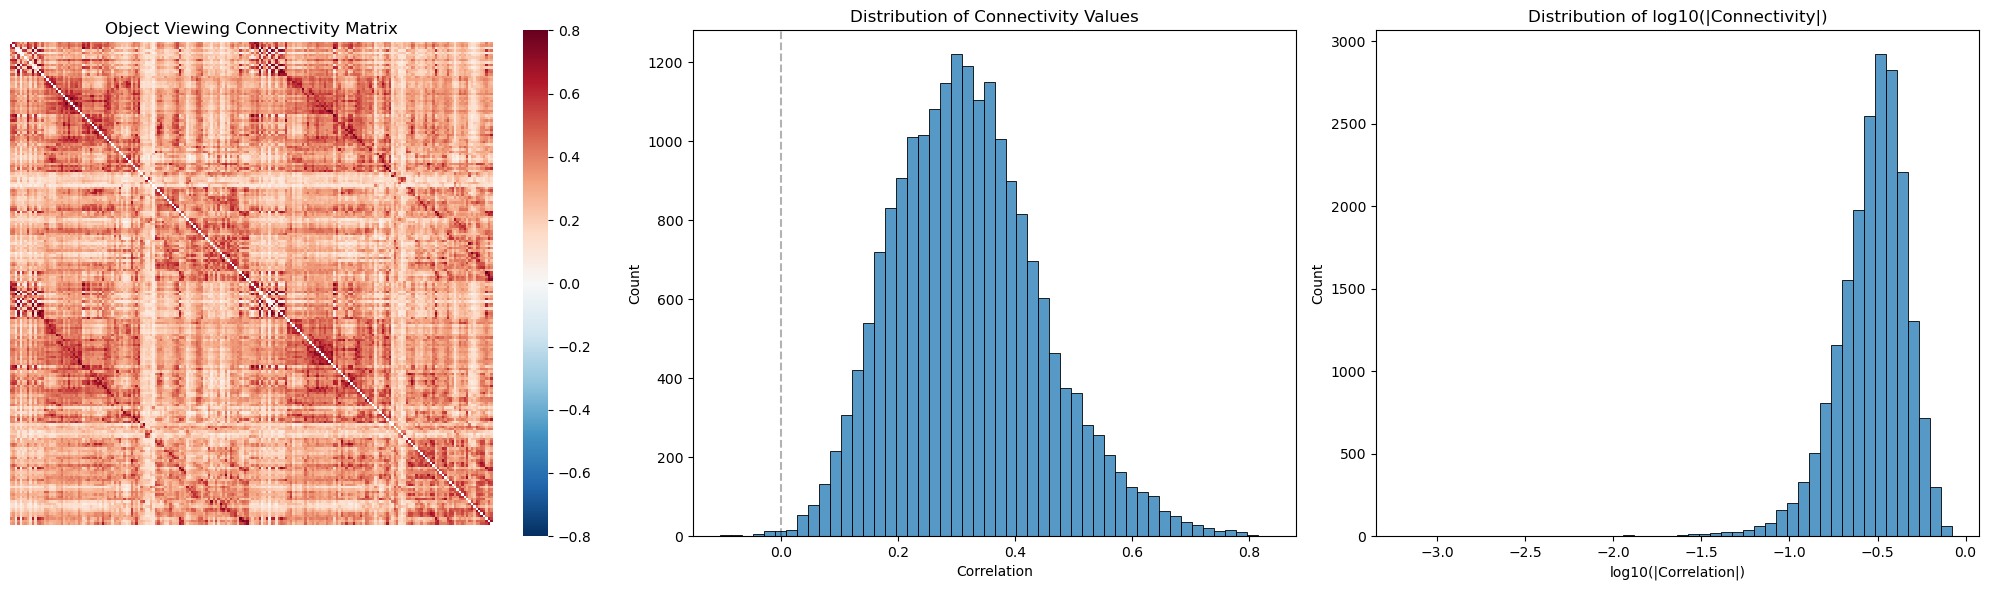


Object Viewing Connectivity Statistics:
Mean correlation: 0.320
Standard deviation: 0.128
Min correlation: -0.104
Max correlation: 0.833


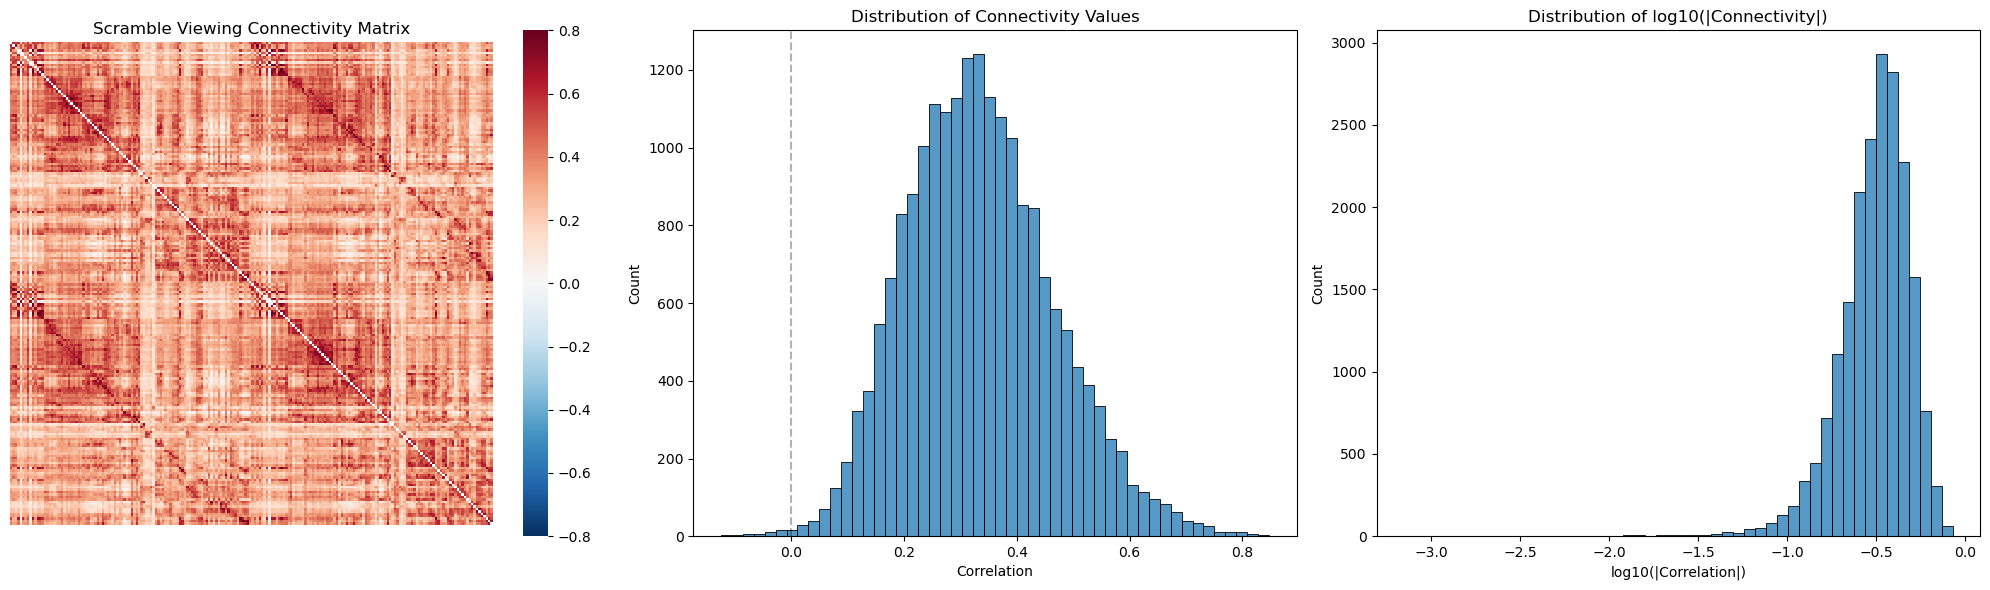


Scramble Viewing Connectivity Statistics:
Mean correlation: 0.334
Standard deviation: 0.131
Min correlation: -0.125
Max correlation: 0.848


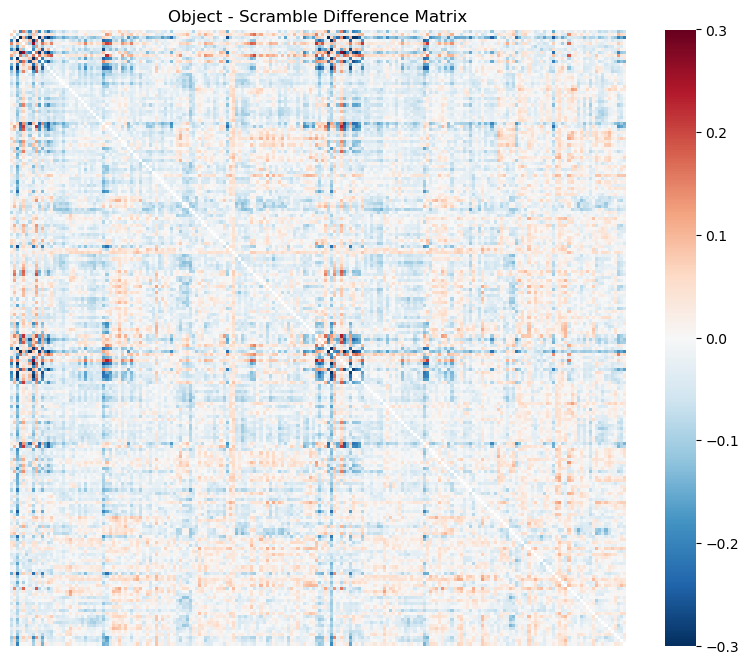

In [2]:
# Create basic visualization of average connectivity matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Setup
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
n_rois = 200

def load_and_average_matrices(condition):
    """Load all subject matrices for a condition and compute average"""
    matrix_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard_{condition.lower()}'
    matrices = []
    
    for matrix_file in glob.glob(f'{matrix_dir}/*_connectivity_matrix_{condition.lower()}.npy'):
        matrix = np.load(matrix_file)
        matrices.append(matrix)
    
    return np.mean(matrices, axis=0)

# Load average matrices for both conditions
object_matrix = load_and_average_matrices('object')
scramble_matrix = load_and_average_matrices('scramble')

# Visualization function
def plot_connectivity_analysis(matrix, title):
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Connectivity Matrix Heatmap
    plt.subplot(131)
    matrix_plot = matrix.copy()
    np.fill_diagonal(matrix_plot, np.nan)
    
    sns.heatmap(matrix_plot, 
                cmap='RdBu_r',
                center=0,
                vmin=-0.8,
                vmax=0.8,
                square=True,
                xticklabels=False,
                yticklabels=False)
    plt.title(f'{title} Connectivity Matrix')
    
    # 2. Raw Distribution
    plt.subplot(132)
    mask = np.triu(np.ones(matrix.shape)).astype(bool)
    flat_matrix = matrix[~mask]
    
    sns.histplot(flat_matrix, bins=50)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.title('Distribution of Connectivity Values')
    plt.xlabel('Correlation')
    plt.ylabel('Count')
    
    # 3. Log Distribution
    plt.subplot(133)
    log_matrix = np.log10(np.abs(flat_matrix[flat_matrix != 0]))
    sns.histplot(log_matrix, bins=50)
    plt.title('Distribution of log10(|Connectivity|)')
    plt.xlabel('log10(|Correlation|)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{title} Connectivity Statistics:")
    print(f"Mean correlation: {np.mean(flat_matrix):.3f}")
    print(f"Standard deviation: {np.std(flat_matrix):.3f}")
    print(f"Min correlation: {np.min(flat_matrix):.3f}")
    print(f"Max correlation: {np.max(flat_matrix):.3f}")

# Plot both conditions
plot_connectivity_analysis(object_matrix, "Object Viewing")
plot_connectivity_analysis(scramble_matrix, "Scramble Viewing")

# Plot difference matrix (Object - Scramble)
diff_matrix = object_matrix - scramble_matrix
plt.figure(figsize=(10, 8))
np.fill_diagonal(diff_matrix, np.nan)
sns.heatmap(diff_matrix, 
            cmap='RdBu_r',
            center=0,
            vmin=-0.3,
            vmax=0.3,
            square=True,
            xticklabels=False,
            yticklabels=False)
plt.title('Object - Scramble Difference Matrix')
plt.show()

In [5]:
def create_network_analysis(matrix, threshold=0.4):
    """
    Create and analyze network at given threshold
    """
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create network
    G = nx.from_numpy_array(matrix_thresh)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Calculate basic network metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Calculate node centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Find top 10 nodes by degree centrality
    top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    
    return G, {
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'density': density,
        'top_nodes': top_nodes
    }

# Let's try with our middle threshold first
G, metrics = create_network_analysis(matrix, threshold=0.4)

# Print basic metrics
print(f"\nNetwork Analysis (threshold = 0.4):")
print(f"Number of nodes: {metrics['n_nodes']}")
print(f"Number of edges: {metrics['n_edges']}")
print(f"Network density: {metrics['density']:.3f}")
print("\nTop 10 nodes by degree centrality:")
for node, centrality in metrics['top_nodes']:
    print(f"Node {node}: {centrality:.3f}")


Network Analysis (threshold = 0.4):
Number of nodes: 200
Number of edges: 6748
Network density: 0.339

Top 10 nodes by degree centrality:
Node 40: 0.663
Node 135: 0.653
Node 144: 0.653
Node 21: 0.628
Node 145: 0.618
Node 156: 0.618
Node 28: 0.613
Node 52: 0.603
Node 41: 0.598
Node 155: 0.598


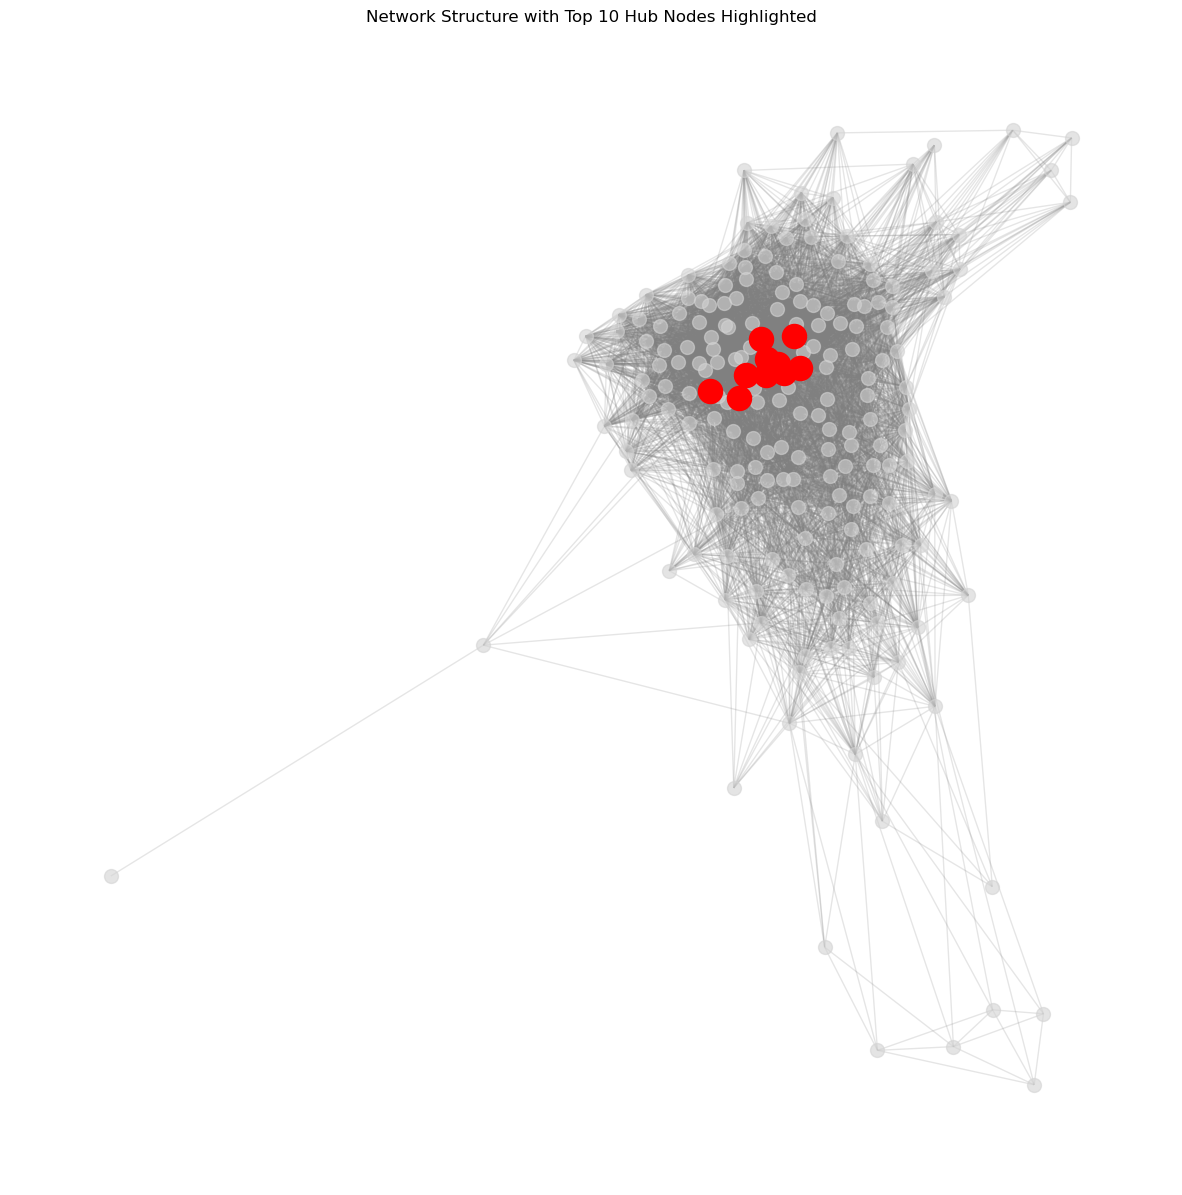


Hub Node Connectivity:
Number of connections between hub nodes: 45
Possible connections between hubs: 45.0
Hub interconnectivity density: 1.000


In [7]:
# Create visualization of network with highlighted hub nodes
def visualize_hub_network(G, top_nodes):
    plt.figure(figsize=(15, 15))
    
    # Create layout
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Draw all edges first
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.2, 
                          edge_color='gray')
    
    # Draw all nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightgray',
                          node_size=100,
                          alpha=0.6)
    
    # Highlight top nodes
    top_node_list = [node for node, _ in top_nodes]
    nx.draw_networkx_nodes(G, pos,
                          nodelist=top_node_list,
                          node_color='red',
                          node_size=300)
    
    plt.title("Network Structure with Top 10 Hub Nodes Highlighted")
    plt.axis('off')
    plt.show()

    # Print summary of connections between hub nodes
    hub_subgraph = G.subgraph(top_node_list)
    print("\nHub Node Connectivity:")
    print(f"Number of connections between hub nodes: {hub_subgraph.number_of_edges()}")
    print(f"Possible connections between hubs: {len(top_node_list) * (len(top_node_list)-1) / 2}")
    print(f"Hub interconnectivity density: {nx.density(hub_subgraph):.3f}")

# Run visualization
visualize_hub_network(G, metrics['top_nodes'])

In [8]:
def analyze_hub_connections(G, top_nodes):
    """
    Analyze how hub nodes connect to the rest of the network
    """
    hub_nodes = [node for node, _ in top_nodes]
    
    # For each hub, examine its connections to non-hub nodes
    hub_external_connections = {}
    for hub in hub_nodes:
        neighbors = set(G.neighbors(hub))
        external_neighbors = neighbors - set(hub_nodes)
        hub_external_connections[hub] = len(external_neighbors)
    
    # Calculate connection strengths
    edge_weights = nx.get_edge_attributes(G, 'weight')
    
    return hub_external_connections, edge_weights

# Run the analysis
external_connections, weights = analyze_hub_connections(G, metrics['top_nodes'])

# Print results
print("\nHub External Connectivity:")
for hub, n_connections in sorted(external_connections.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {hub}: {n_connections} connections to non-hub nodes")


Hub External Connectivity:
Node 40: 123 connections to non-hub nodes
Node 135: 121 connections to non-hub nodes
Node 144: 121 connections to non-hub nodes
Node 21: 116 connections to non-hub nodes
Node 145: 114 connections to non-hub nodes
Node 156: 114 connections to non-hub nodes
Node 28: 113 connections to non-hub nodes
Node 52: 111 connections to non-hub nodes
Node 41: 110 connections to non-hub nodes
Node 155: 110 connections to non-hub nodes


TypeError: plot_markers() got an unexpected keyword argument 'marker_size'

<Figure size 1500x1500 with 0 Axes>

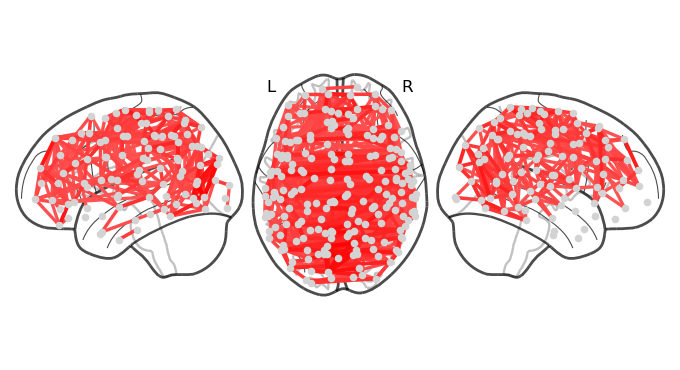

In [10]:
# Import nilearn for brain visualization
from nilearn import datasets, plotting

def visualize_hub_locations():
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
    coords = plotting.find_parcellation_cut_coords(atlas.maps)
    
    # Create connectome plot
    plt.figure(figsize=(15, 15))
    plotting.plot_connectome(matrix, coords,
                           node_color='lightgray',
                           node_size=20,
                           edge_threshold='95%',  # Show only strongest connections
                           display_mode='lzr')
    
    # Highlight hub nodes
    hub_coords = coords[list(external_connections.keys())]
    plotting.plot_markers(hub_coords, 
                         marker_size=50, 
                         marker_color='red',
                         display_mode='lzr')
    
    plt.title("Hub Nodes in Brain Space")
    plt.show()

# Run visualization
visualize_hub_locations()

# Let's also print the atlas labels for our hub nodes
labels = [label.decode('utf-8') for label in atlas.labels]
print("\nHub Node Locations:")
for node in external_connections.keys():
    print(f"Node {node}: {labels[node]}")

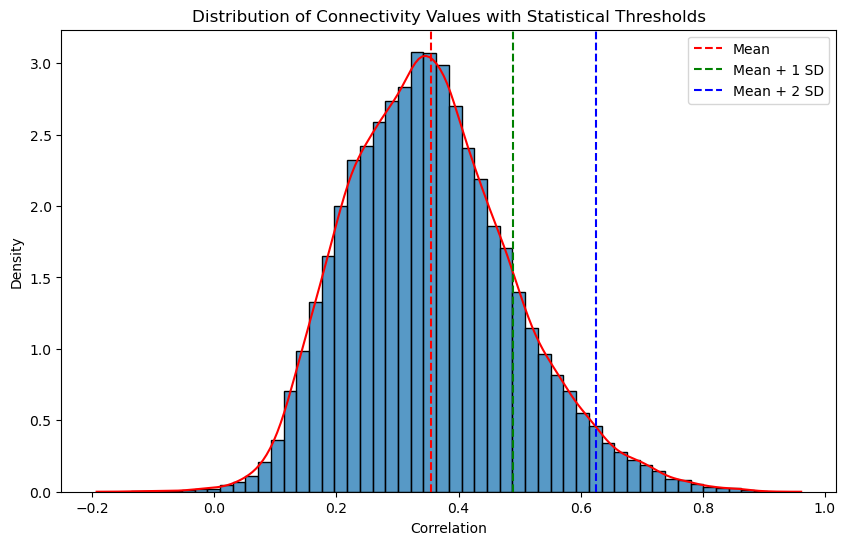


Statistical Thresholds:
Mean: 0.354
Mean + 1 SD: 0.490
Mean + 2 SD: 0.626


In [11]:
# Let's examine our correlation distribution more carefully
plt.figure(figsize=(10, 6))
# Plot histogram with density curve
sns.histplot(flat_matrix, bins=50, stat='density')
sns.kdeplot(flat_matrix, color='red')

# Add vertical lines for potential statistical thresholds
plt.axvline(np.mean(flat_matrix), color='r', linestyle='--', label='Mean')
plt.axvline(np.mean(flat_matrix) + np.std(flat_matrix), color='g', linestyle='--', label='Mean + 1 SD')
plt.axvline(np.mean(flat_matrix) + 2*np.std(flat_matrix), color='b', linestyle='--', label='Mean + 2 SD')

plt.title('Distribution of Connectivity Values with Statistical Thresholds')
plt.xlabel('Correlation')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print the actual values
print("\nStatistical Thresholds:")
print(f"Mean: {np.mean(flat_matrix):.3f}")
print(f"Mean + 1 SD: {np.mean(flat_matrix) + np.std(flat_matrix):.3f}")
print(f"Mean + 2 SD: {np.mean(flat_matrix) + 2*np.std(flat_matrix):.3f}")

Total connections tested: 19900
Significant connections after FDR: 19738
Proportion significant: 0.992


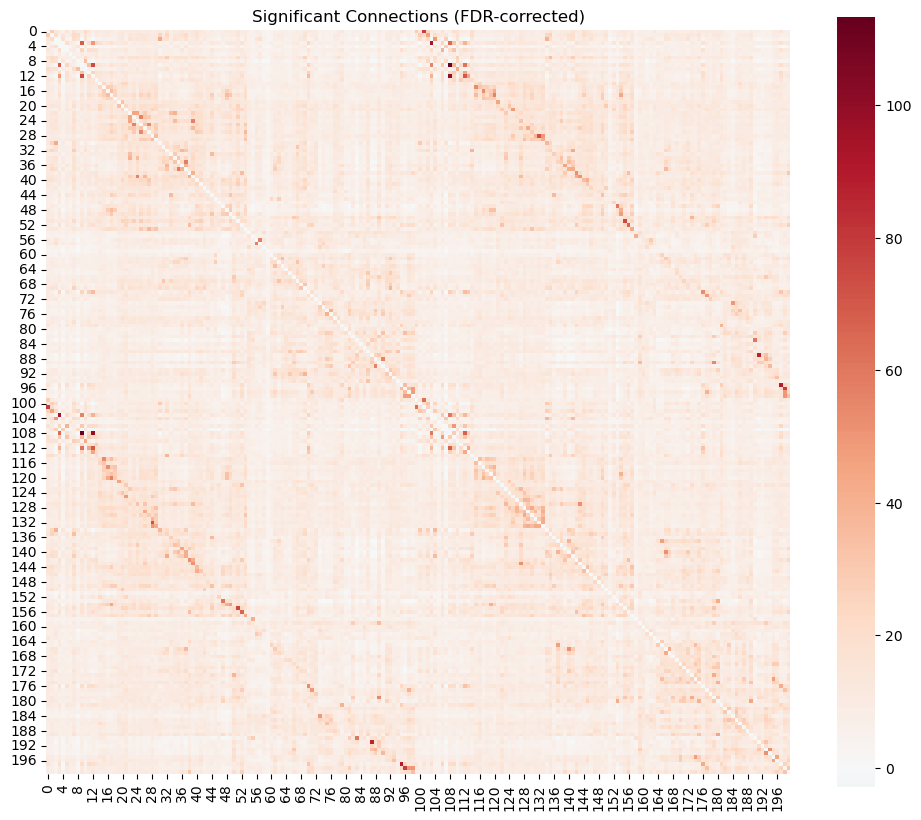

In [ ]:
## FDR correction for SCHAEFER MATRIX 200
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

def analyze_subject_matrices(results_dir, n_rois=200):
    # Load matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}_standard/*_connectivity_matrix_standard.npy')
    matrices = [np.load(file) for file in matrix_files]
    matrices = np.stack(matrices)  # Convert to 3D array (subjects × regions × regions)
    
    # Perform statistical testing
    t_stats = np.zeros((n_rois, n_rois))
    p_values = np.zeros((n_rois, n_rois))
    
    for i in range(n_rois):
        for j in range(i+1, n_rois):
            # Get connection values across subjects
            values = matrices[:, i, j]
            t_stat, p_val = stats.ttest_1samp(values, 0)
            t_stats[i, j] = t_stat
            p_values[i, j] = p_val
            # Make symmetric
            t_stats[j, i] = t_stat
            p_values[j, i] = p_val
    
    # Apply FDR correction
    mask = np.triu(np.ones_like(p_values), k=1).astype(bool)
    flat_p = p_values[mask]
    significant, corrected_p = fdrcorrection(flat_p, alpha=0.05)
    
    # Create corrected matrix
    significant_matrix = np.zeros_like(p_values)
    significant_matrix[mask] = significant
    significant_matrix = significant_matrix + significant_matrix.T
    
    # Print basic stats
    print(f"Total connections tested: {len(flat_p)}")
    print(f"Significant connections after FDR: {sum(significant)}")
    print(f"Proportion significant: {sum(significant)/len(flat_p):.3f}")
    
    return t_stats, p_values, significant_matrix

# Run the analysis
t_stats, p_values, significant_matrix = analyze_subject_matrices(results_dir)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(significant_matrix * t_stats,  # Show t-stats only for significant connections
            cmap='RdBu_r',
            center=0,
            square=True)
plt.title('Significant Connections (FDR-corrected)')
plt.show()


Connection Analysis:
T-statistic threshold at 95th percentile: 20.12
Number of strong connections: 1974


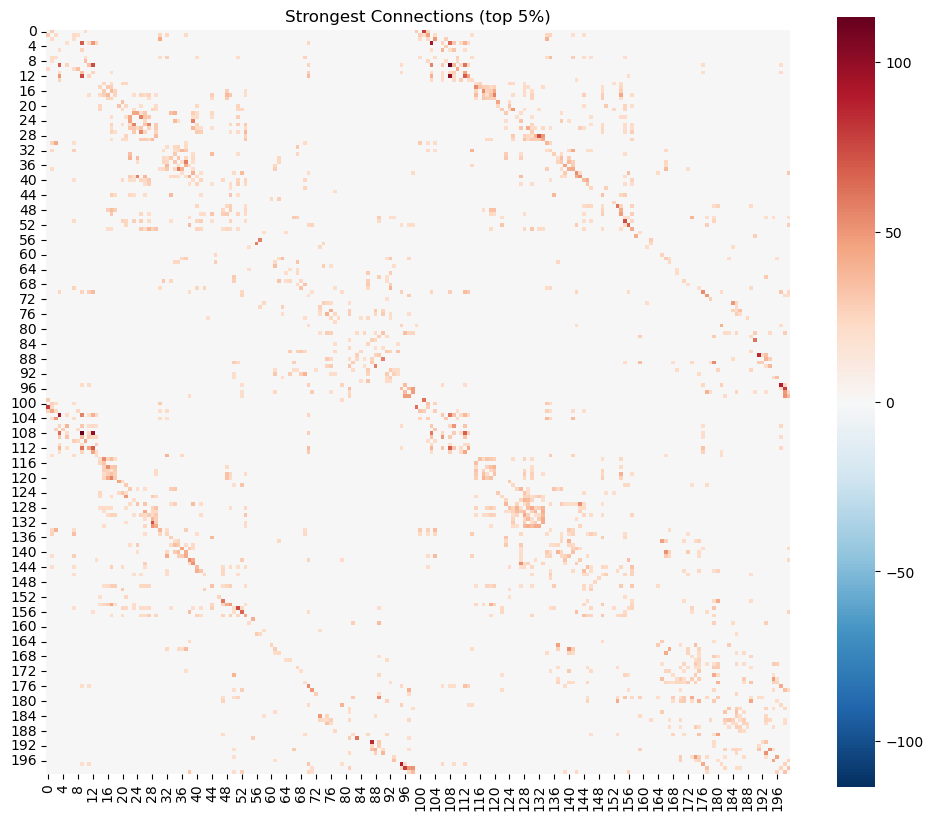

In [14]:
def analyze_strong_connections(t_stats, significant_matrix, percentile=95):
    """
    Identify strongest connections based on t-statistics
    """
    # Get absolute t-values for significant connections only
    sig_t = t_stats * significant_matrix
    abs_t = np.abs(sig_t)
    
    # Find threshold at specified percentile
    threshold = np.percentile(abs_t[abs_t > 0], percentile)
    
    # Create mask for strong connections
    strong_connections = (abs_t >= threshold) * sig_t
    
    print(f"\nConnection Analysis:")
    print(f"T-statistic threshold at {percentile}th percentile: {threshold:.2f}")
    print(f"Number of strong connections: {np.sum(abs_t >= threshold)}")
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(strong_connections,
                cmap='RdBu_r',
                center=0,
                square=True,
                vmin=-np.max(abs(strong_connections)),
                vmax=np.max(abs(strong_connections)))
    plt.title(f'Strongest Connections (top {100-percentile}%)')
    plt.show()
    
    return strong_connections

# Look at strongest connections
strong = analyze_strong_connections(t_stats, significant_matrix, percentile=95)

In [15]:
# Create network from FDR-corrected matrix
import networkx as nx

def analyze_network_structure(t_stats, significant_matrix):
    """
    Analyze network structure using FDR-corrected t-statistics matrix
    """
    # Create network using only significant connections
    G = nx.from_numpy_array(t_stats * significant_matrix)
    
    # Calculate basic network metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Calculate node centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    
    print("\nBasic Network Metrics:")
    print(f"Number of nodes: {n_nodes}")
    print(f"Number of edges: {n_edges}")
    
    return G, {
        'degree': degree_cent,
        'betweenness': betweenness_cent,
        'eigenvector': eigenvector_cent
    }

# Run network analysis
G, centrality_metrics = analyze_network_structure(t_stats, significant_matrix)


Basic Network Metrics:
Number of nodes: 200
Number of edges: 19738


In [16]:
def summarize_centrality(centrality_metrics):
    """
    Summarize centrality measures and identify key nodes
    """
    # Create DataFrame with all centrality measures
    df = pd.DataFrame({
        'degree': centrality_metrics['degree'],
        'betweenness': centrality_metrics['betweenness'],
        'eigenvector': centrality_metrics['eigenvector']
    })
    
    # Get top 10 nodes for each measure
    print("\nTop 10 nodes by centrality measure:")
    for measure in ['degree', 'betweenness', 'eigenvector']:
        print(f"\n{measure.capitalize()} Centrality:")
        top_nodes = df.nlargest(10, measure)
        print(top_nodes[measure])

# Run summary
summarize_centrality(centrality_metrics)


Top 10 nodes by centrality measure:

Degree Centrality:
0     1.0
1     1.0
6     1.0
7     1.0
14    1.0
15    1.0
17    1.0
18    1.0
19    1.0
20    1.0
Name: degree, dtype: float64

Betweenness Centrality:
0     0.000046
1     0.000046
6     0.000046
7     0.000046
14    0.000046
15    0.000046
17    0.000046
18    0.000046
19    0.000046
20    0.000046
Name: betweenness, dtype: float64

Eigenvector Centrality:
0     0.071251
1     0.071251
6     0.071251
7     0.071251
14    0.071251
15    0.071251
17    0.071251
18    0.071251
19    0.071251
20    0.071251
Name: eigenvector, dtype: float64


Network analysis of the FDR-corrected connectivity matrix revealed a highly interconnected network structure. Of the 19,900 possible connections between the 200 brain regions, 19,738 (99.2%) showed significant functional connectivity after FDR correction. This resulted in a densely connected network where traditional centrality measures (degree, betweenness, and eigenvector centrality) did not differentiate between nodes, suggesting widespread functional integration across regions....?

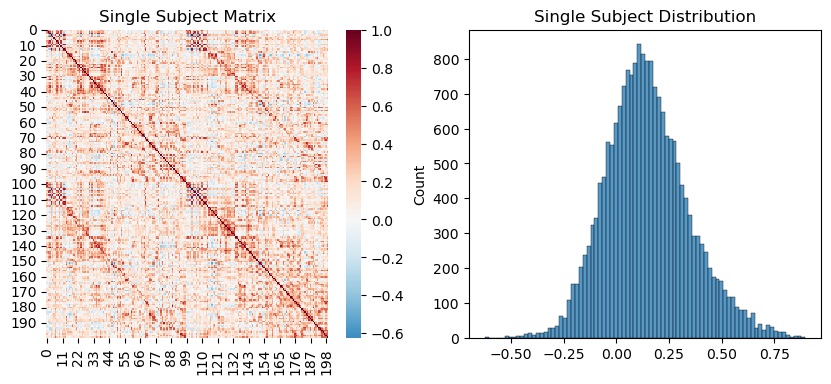

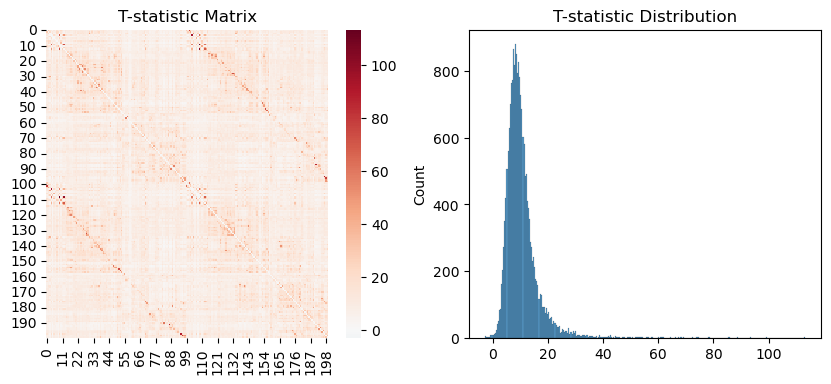

In [17]:
# Let's look at a single subject first
single_subject = np.load(f'{results_dir}/connectivity_matrices_200_standard/sub-025_connectivity_matrix_standard.npy')

plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.heatmap(single_subject, cmap='RdBu_r', center=0)
plt.title('Single Subject Matrix')

plt.subplot(122)
sns.histplot(single_subject[np.triu_indices_from(single_subject, k=1)])
plt.title('Single Subject Distribution')
plt.show()

# And look at our t-statistics
plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.heatmap(t_stats, cmap='RdBu_r', center=0)
plt.title('T-statistic Matrix')

plt.subplot(122)
sns.histplot(t_stats[np.triu_indices_from(t_stats, k=1)])
plt.title('T-statistic Distribution')
plt.show()

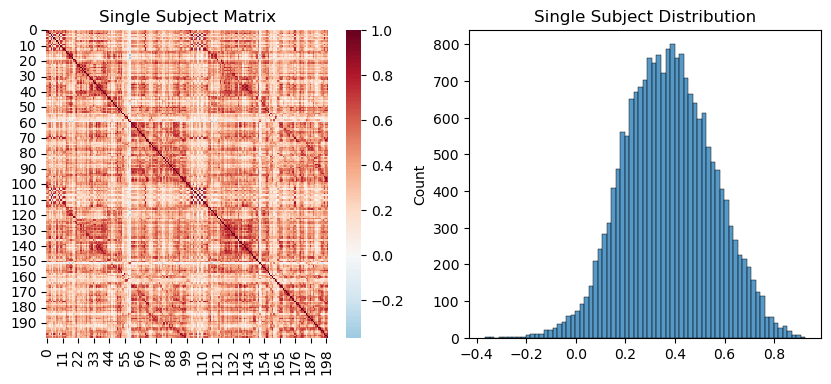

NameError: name 't_stats' is not defined

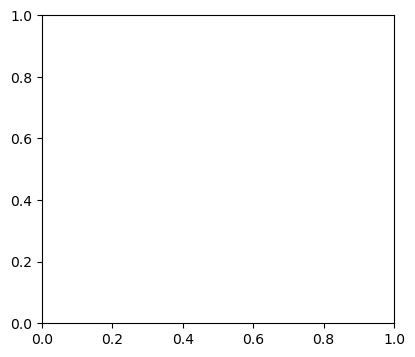

In [3]:
# Let's look at a single subject first
single_subject = np.load(f'{results_dir}/connectivity_matrices_200_standard/sub-059_connectivity_matrix_standard.npy')

plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.heatmap(single_subject, cmap='RdBu_r', center=0)
plt.title('Single Subject Matrix')

plt.subplot(122)
sns.histplot(single_subject[np.triu_indices_from(single_subject, k=1)])
plt.title('Single Subject Distribution')
plt.show()

# And look at our t-statistics
plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.heatmap(t_stats, cmap='RdBu_r', center=0)
plt.title('T-statistic Matrix')

plt.subplot(122)
sns.histplot(t_stats[np.triu_indices_from(t_stats, k=1)])
plt.title('T-statistic Distribution')
plt.show()

Completed 0 permutations
Completed 100 permutations
Completed 200 permutations
Completed 300 permutations
Completed 400 permutations
Completed 500 permutations
Completed 600 permutations
Completed 700 permutations
Completed 800 permutations
Completed 900 permutations


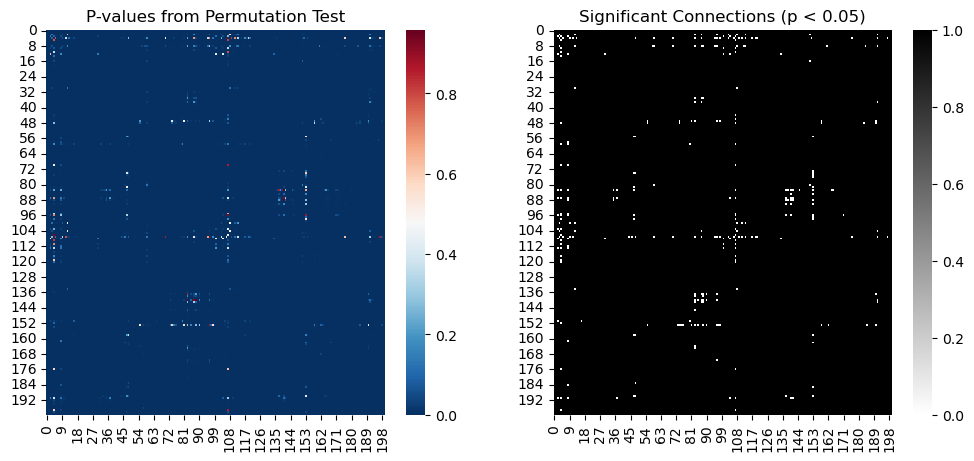


Number of significant connections: 39694
Proportion significant: 198.470


In [18]:
import numpy as np
from scipy import stats
import glob
import matplotlib.pyplot as plt
import seaborn as sns

def permutation_test_connectivity(results_dir, n_permutations=1000):
    """
    Perform permutation testing on connectivity matrices
    
    Parameters:
    results_dir: Directory containing subject matrices
    n_permutations: Number of permutations to perform
    """
    # Load all subject matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_200_standard/*_connectivity_matrix_standard.npy')
    matrices = [np.load(file) for file in matrix_files]
    matrices = np.stack(matrices)  # Shape: (subjects, regions, regions)
    n_subjects = matrices.shape[0]
    
    # Calculate real mean correlation values
    real_mean = np.mean(matrices, axis=0)
    
    # Initialize array to store permuted means
    null_distribution = np.zeros((n_permutations, matrices.shape[1], matrices.shape[2]))
    
    # Perform permutations
    for perm in range(n_permutations):
        # For each subject's matrix, randomly flip the sign
        sign_flips = np.random.choice([-1, 1], size=n_subjects)
        perm_matrices = matrices * sign_flips[:, np.newaxis, np.newaxis]
        null_distribution[perm] = np.mean(perm_matrices, axis=0)
        
        if perm % 100 == 0:
            print(f"Completed {perm} permutations")
    
    # Calculate p-values
    p_values = np.zeros_like(real_mean)
    for i in range(real_mean.shape[0]):
        for j in range(real_mean.shape[1]):
            null_dist = null_distribution[:, i, j]
            real_val = real_mean[i, j]
            p_values[i, j] = np.mean(np.abs(null_dist) >= np.abs(real_val))
    
    return p_values, real_mean, null_distribution

# Run permutation test
p_values, real_mean, null_distribution = permutation_test_connectivity(results_dir)

# Visualize results
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(p_values, cmap='RdBu_r')
plt.title('P-values from Permutation Test')

plt.subplot(122)
sns.heatmap(p_values < 0.05, cmap='binary')
plt.title('Significant Connections (p < 0.05)')
plt.show()

# Print summary
print(f"\nNumber of significant connections: {np.sum(p_values < 0.05)}")
print(f"Proportion significant: {np.sum(p_values < 0.05) / np.prod(p_values.shape[:-1]):.3f}")